# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                        
Sample_062  P22676                                                    9.985
Sample_042  P27169                                                   18.980
Sample_045  A6XMH3;P01236;Q5I0G2                                     13.106
Sample_001  Q14982;Q14982-2;Q14982-4                                 19.013
Sample_057  A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2   14.586
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups
Sample_144  P48147           10.459
Sample_051  Q6NUJ2           14.215
Sample_137  I3L145;P04278    14.799
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.980
            A0A075B6Q5                 13.833
            A0A075B6R2                 12.883
            A0A075B6S5                 13.788
            A0A087WSY4                 13.759
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.974
            Q9UI40;Q9UI40-2            13.198
            Q9UIW2                     14.224
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.470
            Q9UP79                     11.575
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.403,15.050,16.842,19.863,13.993,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.258,19.067,...,15.528,15.576,12.443,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.175,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.677,17.705,17.039,14.805,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,7.790,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.762,15.345,17.084,18.708,14.249,19.433,7.449,9.830
Sample_207,15.739,16.877,15.469,16.898,14.062,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.364,12.154,13.021,13.025,13.103,13.443,12.637,13.081,13.051,13.217
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.244,19.067,16.127,...,11.975,13.363,12.832,12.223,12.353,13.583,13.327,13.329,12.509,12.065
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.899,12.383,12.095,13.006,12.462,12.611,11.690,13.088,12.643,13.426
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.644,11.850,13.969,12.573,11.624,14.837,11.774,13.194,10.663,12.957
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.027,14.119,11.931,12.905,12.706,12.766,13.558,12.912,12.107,13.801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.885,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 356.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.53it/s]

100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

100%|██████████| 3/3 [00:00<00:00,  6.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.25it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.84it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.89it/s]

100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.59it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.30it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.64it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.61it/s]

100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.72it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.21it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.04it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.96it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.01it/s]

100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.40it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.17it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.85it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.84it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.10it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.20it/s]

100%|██████████| 8/8 [00:01<00:00,  4.20it/s]

100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.16it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.12it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.15it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.92it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.65it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.60it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.61it/s]

100%|██████████| 9/9 [00:01<00:00,  4.51it/s]

100%|██████████| 9/9 [00:01<00:00,  4.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.97it/s]

 30%|███       | 3/10 [00:00<00:01,  5.63it/s]

 40%|████      | 4/10 [00:00<00:01,  5.04it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.93it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.58it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.43it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.42it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.46it/s]

100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.37it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.18it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.58it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.01it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.94it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.86it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.27it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.42it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.02it/s]

100%|██████████| 11/11 [00:02<00:00,  2.79it/s]

100%|██████████| 11/11 [00:02<00:00,  3.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.64it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.67it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.87it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.10it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.74it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.52it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.47it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.48it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.41it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.47it/s]

100%|██████████| 12/12 [00:04<00:00,  2.76it/s]

100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.70it/s]

 31%|███       | 4/13 [00:00<00:02,  4.04it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.31it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.84it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.67it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.63it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.69it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.71it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.72it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.87it/s]

100%|██████████| 13/13 [00:04<00:00,  3.27it/s]

100%|██████████| 13/13 [00:04<00:00,  3.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.99it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.41it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.90it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.05it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.72it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.63it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.49it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.47it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.60it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.76it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.87it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.14it/s]

100%|██████████| 14/14 [00:04<00:00,  3.40it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 10.11it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.95it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.23it/s]

 40%|████      | 6/15 [00:01<00:03,  2.77it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.64it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.53it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.51it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.67it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.92it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.98it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.91it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.89it/s]

100%|██████████| 15/15 [00:05<00:00,  2.95it/s]

100%|██████████| 15/15 [00:05<00:00,  2.97it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.034 0.008          0.785 0.323       0.125   
2             0.005 0.004      0.047 0.020          0.672 0.097       0.570   
3             0.004 0.003      0.050 0.024          0.665 0.111       0.567   
4             0.004 0.003      0.045 0.021          0.676 0.109       0.578   
5             0.004 0.003      0.053 0.028          0.780 0.091       0.800   
6             0.004 0.002      0.036 0.007          0.773 0.091       0.797   
7             0.004 0.002      0.037 0.010          0.780 0.085       0.806   
8             0.005 0.005      0.055 0.028          0.787 0.085       0.806   
9             0.007 0.006      0.067 0.029          0.786 0.086       0.804   
10            0.008 0.007      0.062 0.028          0.793 0.087       0.808   
11            0.007 0.007      0.057 0.022          0.790 0.083       0.806   
12            0.005 0.005      0.044 0.024          0.789 0.082       0.822   
13            0.005 0.005      0.048 0.021          0.790 0.078       0.782   
14            0.004 0.003      0.046 0.017          0.790 0.078       0.783   
15            0.005 0.004      0.044 0.017          0.807 0.078       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.207 0.133                  0.554 0.044        0.856   
2          0.125   0.610 0.094                  0.682 0.067        0.749   
3          0.116   0.606 0.097                  0.677 0.071        0.741   
4          0.123   0.616 0.098                  0.685 0.070        0.741   
5          0.113   0.785 0.081                  0.816 0.069        0.896   
6          0.113   0.780 0.081                  0.811 0.071        0.894   
7          0.110   0.788 0.077                  0.819 0.066        0.893   
8          0.111   0.792 0.075                  0.822 0.064        0.894   
9          0.102   0.790 0.073                  0.820 0.062        0.892   
10         0.115   0.797 0.084                  0.826 0.072        0.908   
11         0.115   0.794 0.080                  0.824 0.069        0.906   
12         0.101   0.801 0.074                  0.829 0.065        0.906   
13         0.109   0.781 0.074                  0.814 0.062        0.908   
14         0.109   0.782 0.075                  0.814 0.063        0.906   
15         0.099   0.799 0.069                  0.829 0.059        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.821 0.085        210.000 0.000  
2          0.071                  0.700 0.087        210.000 0.000  
3          0.073                  0.692 0.091        210.000 0.000  
4          0.069                  0.695 0.084        210.000 0.000  
5          0.051                  0.876 0.056        210.000 0.000  
6          0.050                  0.871 0.056        210.000 0.000  
7          0.051                  0.867 0.057        210.000 0.000  
8          0.049                  0.868 0.056        210.000 0.000  
9          0.051                  0.869 0.057        210.000 0.000  
10         0.050                  0.888 0.058        210.000 0.000  
11         0.051                  0.885 0.061        210.000 0.000  
12         0.052                  0.885 0.060        210.000 0.000  
13         0.050                  0.889 0.061        210.000 0.000  
14         0.051                  0.887 0.061        210.000 0.000  
15         0.049                  0.894 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 504.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.77it/s]

100%|██████████| 2/2 [00:00<00:00,  7.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.79it/s]

100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

100%|██████████| 3/3 [00:00<00:00,  3.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.89it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.42it/s]

100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.08it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.94it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

100%|██████████| 5/5 [00:01<00:00,  3.38it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.91it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.54it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.03it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

100%|██████████| 6/6 [00:01<00:00,  3.73it/s]

100%|██████████| 6/6 [00:01<00:00,  4.14it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.30it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.40it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.55it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.59it/s]

100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.76it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.02it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.09it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.53it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.89it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.91it/s]

100%|██████████| 8/8 [00:01<00:00,  3.93it/s]

100%|██████████| 8/8 [00:01<00:00,  4.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.55it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.65it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.01it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.82it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.66it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.45it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.71it/s]

100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

100%|██████████| 9/9 [00:03<00:00,  2.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.45it/s]

 30%|███       | 3/10 [00:00<00:01,  5.59it/s]

 40%|████      | 4/10 [00:00<00:01,  4.83it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.42it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.28it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.02it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.26it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.15it/s]

100%|██████████| 10/10 [00:02<00:00,  2.91it/s]

100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.49it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.52it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.03it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.87it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.06it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.19it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.99it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.14it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.25it/s]

100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.73it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.58it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.26it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.98it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.82it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.80it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.79it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.98it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.68it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.51it/s]

100%|██████████| 12/12 [00:03<00:00,  2.47it/s]

100%|██████████| 12/12 [00:03<00:00,  3.15it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.20it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.08it/s]

 31%|███       | 4/13 [00:01<00:02,  3.05it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.84it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.74it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.89it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.79it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.83it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.86it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.94it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

100%|██████████| 13/13 [00:04<00:00,  3.00it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.24it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.01it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.74it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.71it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.35it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.26it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.32it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.23it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.35it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.55it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.75it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.70it/s]

100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.71it/s]

 20%|██        | 3/15 [00:00<00:03,  3.80it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.27it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.07it/s]

 40%|████      | 6/15 [00:01<00:03,  2.70it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.73it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.67it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.60it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.20it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.16it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.10it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.28it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.43it/s]

100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

100%|██████████| 15/15 [00:05<00:00,  2.61it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.076 0.027          0.874 0.206       0.161   
2             0.003 0.000      0.036 0.004          0.691 0.106       0.648   
3             0.004 0.002      0.048 0.019          0.695 0.104       0.635   
4             0.006 0.006      0.059 0.026          0.726 0.095       0.674   
5             0.004 0.004      0.044 0.019          0.717 0.097       0.687   
6             0.003 0.002      0.036 0.010          0.713 0.099       0.682   
7             0.004 0.001      0.039 0.011          0.804 0.088       0.754   
8             0.003 0.001      0.037 0.009          0.791 0.089       0.748   
9             0.004 0.002      0.038 0.008          0.811 0.086       0.813   
10            0.004 0.003      0.046 0.019          0.809 0.088       0.811   
11            0.005 0.004      0.048 0.017          0.813 0.084       0.798   
12            0.004 0.000      0.040 0.010          0.826 0.081       0.800   
13            0.004 0.000      0.038 0.008          0.828 0.077       0.814   
14            0.008 0.008      0.070 0.032          0.825 0.075       0.810   
15            0.004 0.004      0.043 0.016          0.851 0.073       0.830   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.262 0.121                  0.572 0.042        0.853   
2          0.128   0.660 0.089                  0.714 0.070        0.793   
3          0.129   0.654 0.088                  0.711 0.069        0.792   
4          0.115   0.692 0.083                  0.741 0.067        0.823   
5          0.112   0.696 0.082                  0.742 0.068        0.819   
6          0.119   0.691 0.086                  0.738 0.070        0.817   
7          0.095   0.773 0.066                  0.807 0.053        0.896   
8          0.100   0.763 0.069                  0.799 0.055        0.893   
9          0.109   0.806 0.067                  0.835 0.054        0.908   
10         0.114   0.803 0.072                  0.833 0.059        0.907   
11         0.102   0.800 0.069                  0.830 0.058        0.915   
12         0.107   0.808 0.071                  0.837 0.058        0.917   
13         0.104   0.816 0.068                  0.844 0.056        0.923   
14         0.105   0.813 0.071                  0.841 0.058        0.920   
15         0.099   0.836 0.067                  0.861 0.055        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.088        210.000 0.000  
2          0.073                  0.733 0.092        210.000 0.000  
3          0.074                  0.722 0.094        210.000 0.000  
4          0.064                  0.788 0.086        210.000 0.000  
5          0.062                  0.779 0.091        210.000 0.000  
6          0.063                  0.775 0.092        210.000 0.000  
7          0.047                  0.877 0.058        210.000 0.000  
8          0.049                  0.876 0.056        210.000 0.000  
9          0.045                  0.889 0.053        210.000 0.000  
10         0.046                  0.887 0.054        210.000 0.000  
11         0.042                  0.889 0.056        210.000 0.000  
12         0.041                  0.892 0.056        210.000 0.000  
13         0.040                  0.904 0.049        210.000 0.000  
14         0.042                  0.901 0.052        210.000 0.000  
15         0.044                  0.910 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1038.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 37.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 32.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 25.09it/s]

100%|██████████| 4/4 [00:00<00:00, 21.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.11it/s]

100%|██████████| 5/5 [00:00<00:00, 17.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.20it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.41it/s]

100%|██████████| 6/6 [00:00<00:00, 14.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.66it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.89it/s]

100%|██████████| 7/7 [00:00<00:00, 16.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.77it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.77it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.67it/s]

100%|██████████| 8/8 [00:00<00:00, 14.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.65it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.09it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.61it/s]

100%|██████████| 9/9 [00:00<00:00, 15.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 27.24it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.77it/s]

 90%|█████████ | 9/10 [00:00<00:00, 16.65it/s]

100%|██████████| 10/10 [00:00<00:00, 16.84it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.02it/s]

 36%|███▋      | 4/11 [00:00<00:00, 15.26it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 13.27it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.41it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.25it/s]

100%|██████████| 11/11 [00:00<00:00, 14.35it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.29it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.73it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.22it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 13.30it/s]

100%|██████████| 12/12 [00:00<00:00, 12.63it/s]

100%|██████████| 12/12 [00:00<00:00, 13.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.36it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.44it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.87it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.20it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.77it/s]

100%|██████████| 13/13 [00:00<00:00, 13.32it/s]

100%|██████████| 13/13 [00:00<00:00, 14.05it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.43it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.34it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.00it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.05it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.33it/s]

100%|██████████| 14/14 [00:00<00:00, 14.83it/s]

100%|██████████| 14/14 [00:00<00:00, 15.67it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 25.70it/s]

 40%|████      | 6/15 [00:00<00:00, 18.23it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.95it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.17it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.35it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.23it/s]

100%|██████████| 15/15 [00:00<00:00, 16.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.045 0.017          0.000 0.000       0.000   
2             0.003 0.004      0.028 0.009          0.559 0.128       0.371   
3             0.004 0.002      0.039 0.013          0.588 0.123       0.437   
4             0.005 0.005      0.042 0.013          0.549 0.119       0.404   
5             0.003 0.001      0.038 0.009          0.560 0.111       0.404   
6             0.004 0.002      0.041 0.014          0.547 0.119       0.404   
7             0.004 0.004      0.042 0.016          0.533 0.115       0.403   
8             0.006 0.006      0.062 0.026          0.518 0.104       0.393   
9             0.005 0.004      0.047 0.016          0.530 0.094       0.454   
10            0.006 0.005      0.061 0.023          0.528 0.098       0.448   
11            0.004 0.003      0.046 0.017          0.549 0.106       0.458   
12            0.004 0.003      0.047 0.019          0.535 0.102       0.457   
13            0.006 0.007      0.057 0.025          0.535 0.096       0.455   
14            0.007 0.007      0.063 0.027          0.562 0.096       0.485   
15            0.009 0.010      0.065 0.028          0.581 0.089       0.501   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.707   
2          0.112   0.439 0.111                  0.577 0.072        0.656   
3          0.109   0.494 0.100                  0.603 0.074        0.670   
4          0.118   0.458 0.107                  0.579 0.073        0.659   
5          0.087   0.462 0.078                  0.581 0.062        0.660   
6          0.108   0.457 0.097                  0.576 0.071        0.656   
7          0.109   0.450 0.096                  0.568 0.071        0.646   
8          0.100   0.440 0.092                  0.560 0.067        0.639   
9          0.110   0.482 0.090                  0.579 0.064        0.668   
10         0.107   0.478 0.086                  0.575 0.065        0.662   
11         0.113   0.493 0.096                  0.590 0.071        0.660   
12         0.107   0.487 0.094                  0.582 0.070        0.656   
13         0.113   0.485 0.091                  0.582 0.066        0.659   
14         0.100   0.515 0.083                  0.602 0.064        0.666   
15         0.110   0.531 0.087                  0.617 0.061        0.696   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.666 0.091        210.000 0.000  
2          0.080                  0.600 0.091        210.000 0.000  
3          0.078                  0.593 0.087        210.000 0.000  
4          0.075                  0.586 0.082        210.000 0.000  
5          0.071                  0.595 0.078        210.000 0.000  
6          0.075                  0.593 0.085        210.000 0.000  
7          0.077                  0.581 0.086        210.000 0.000  
8          0.079                  0.578 0.086        210.000 0.000  
9          0.078                  0.610 0.088        210.000 0.000  
10         0.076                  0.603 0.086        210.000 0.000  
11         0.077                  0.608 0.088        210.000 0.000  
12         0.078                  0.603 0.090        210.000 0.000  
13         0.077                  0.609 0.088        210.000 0.000  
14         0.076                  0.618 0.089        210.000 0.000  
15         0.072                  0.643 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,14,15
score_time,9,1,15
test_precision,15,1,3
test_recall,12,15,15
test_f1,12,15,15
test_balanced_accuracy,12,15,15
test_roc_auc,15,15,1
test_average_precision,15,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.96it/s]

 20%|██        | 3/15 [00:00<00:03,  3.44it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.94it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.56it/s]

 40%|████      | 6/15 [00:02<00:03,  2.37it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.35it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.44it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.52it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.56it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.74it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.63it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.78it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.95it/s]

100%|██████████| 15/15 [00:05<00:00,  3.17it/s]

100%|██████████| 15/15 [00:05<00:00,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1146.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.49it/s]

 20%|██        | 3/15 [00:00<00:03,  3.87it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.82it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.35it/s]

 40%|████      | 6/15 [00:01<00:02,  3.03it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.91it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.83it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.07it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.20it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.38it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.26it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.31it/s]

100%|██████████| 15/15 [00:04<00:00,  3.46it/s]

100%|██████████| 15/15 [00:04<00:00,  3.31it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


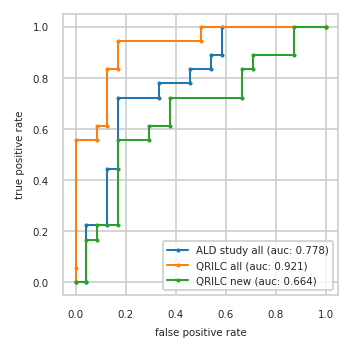

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.042 0.000
2          0.042 0.222     0.000 0.556     0.042 0.167
3          0.125 0.222     0.083 0.556     0.083 0.167
4          0.125 0.444     0.083 0.611     0.083 0.222
5          0.167 0.444     0.125 0.611     0.167 0.222
6          0.167 0.722     0.125 0.833     0.167 0.556
7          0.333 0.722     0.167 0.833     0.292 0.556
8          0.333 0.778     0.167 0.944     0.292 0.611
9          0.458 0.778     0.500 0.944     0.375 0.611
10         0.458 0.833     0.500 1.000     0.375 0.722
11         0.542 0.833     1.000 1.000     0.667 0.722
12         0.542 0.889       NaN   NaN     0.667 0.833
13         0.583 0.889       NaN   NaN     0.708 0.833
14         0.583 1.000       NaN   NaN     0.708 0.889
15         1.000 1.000       NaN   NaN     0.875 0.889
16           NaN   NaN       NaN   NaN     0.875 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,P31321
1,A0A087X136;P51801,Q8NBI6,None
2,G3XAI2;P07942,D6RGG3;Q99715,None
3,P04075,Q9Y2T3;Q9Y2T3-3,None
4,Q99983,P61981,None
5,P61981,P14174,None
6,P14174,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,None
7,Q9Y2T3;Q9Y2T3-3,P04075,None
8,P00338;P00338-3,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


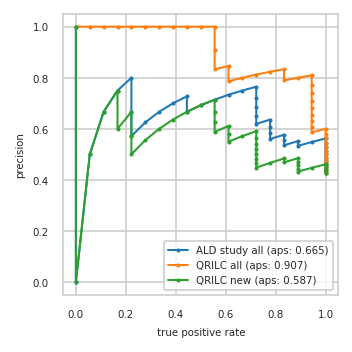

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.533 0.889     0.600 1.000     0.467 0.778
13         0.552 0.889     0.586 0.944     0.448 0.722
14         0.536 0.833     0.607 0.944     0.464 0.722
15         0.556 0.833     0.630 0.944     0.481 0.722
16         0.577 0.833     0.654 0.944     0.500 0.722
17         0.560 0.778     0.680 0.944     0.520 0.722
18         0.583 0.778     0.708 0.944     0.542 0.722
19         0.609 0.778     0.739 0.944     0.565 0.722
20         0.636 0.778     0.773 0.944     0.591 0.722
21         0.619 0.722     0.810 0.944     0.571 0.667
22         0.650 0.722     0.800 0.889     0.550 0.611
23         0.684 0.722     0.789 0.833     0.579 0.611
24         0.722 0.722     0.833 0.833     0.611 0.611
25         0.765 0.722     0.824 0.778     0.588 0.556
26         0.750 0.667     0.812 0.722     0.625 0.556
27         0.733 0.611     0.800 0.667     0.667 0.556
28         0.714 0.556     0.786 0.611     0.714 0.556
29         0.692 0.500     0.846 0.611     0.692 0.500
30         0.667 0.444     0.833 0.556     0.667 0.444
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.700 0.389     1.000 0.556     0.600 0.333
33         0.667 0.333     1.000 0.500     0.556 0.278
34         0.625 0.278     1.000 0.444     0.500 0.222
35         0.571 0.222     1.000 0.389     0.571 0.222
36         0.667 0.222     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


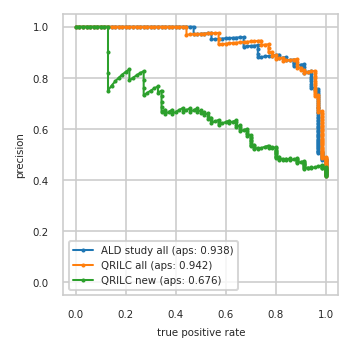

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


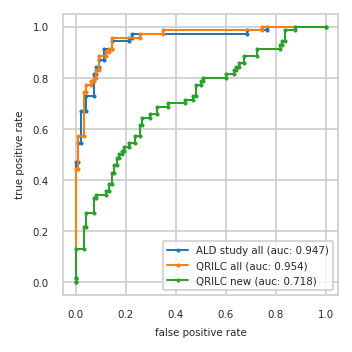

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}